In [2]:
import pandas as pd
import os
import numpy as np
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances
import networkx as nx
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import math
from sklearn.metrics import calinski_harabasz_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# датасет https://www.kaggle.com/datasets/nikhil7280/student-performance-multiple-linear-regression/data

# датасет 2 https://www.kaggle.com/datasets/rakeshkapilavai/extrovert-vs-introvert-behavior-data

In [3]:
# Метрики расстояний
def euclidean_distance(p1, p2):
    return math.sqrt(sum((a - b) ** 2 for a, b in zip(p1, p2)))
def euclidean_distance2(p1, p2):
    return sum((a - b) ** 2 for a, b in zip(p1, p2))
def manhattan_distance(p1, p2):
    return sum(abs(a - b) for a, b in zip(p1, p2))
def chebyshev_distance(p1, p2):
    return max(abs(a - b) for a, b in zip(p1, p2))
def minkowski_distance(p1, p2, p, r):
    return sum(abs(a - b) ** p for a, b in zip(p1, p2)) ** (1 / r)
def mahalanobis_distance(p1, p2, cov_inv):
    delta = np.array(p1) - np.array(p2)
    return np.sqrt(np.dot(np.dot(delta.T, cov_inv), delta))
def spearman_rank_correlation(x, y):
    n = len(x)
    rank_x = {val: rank for rank, val in enumerate(sorted(x), 1)}
    rank_y = {val: rank for rank, val in enumerate(sorted(y), 1)}
    d_squared = sum((rank_x[a] - rank_y[b]) ** 2 for a, b in zip(x, y))
    return 1 - (6 * d_squared) / (n * (n**2 - 1))
def kendall_tau(x, y):
    n = len(x)
    concordant = discordant = 0
    for i in range(n):
        for j in range(i + 1, n):
            a = x[i] - x[j]
            b = y[i] - y[j]
            if a * b > 0:
                concordant += 1
            elif a * b < 0:
                discordant += 1
    return (concordant - discordant) / (0.5 * n * (n - 1))
def pearson_correlation(x, y):
    n = len(x)
    mean_x = sum(x) / n
    mean_y = sum(y) / n
    num = sum((a - mean_x) * (b - mean_y) for a, b in zip(x, y))
    den_x = sum((a - mean_x) ** 2 for a in x)
    den_y = sum((b - mean_y) ** 2 for b in y)
    return num / math.sqrt(den_x * den_y)


2. Загрузка и первичная обработка данных

In [5]:
data = pd.read_excel('dataset5.xlsx')
print("Типы данных в датасете:")
print(data.dtypes)

Типы данных в датасете:
Time_spent_Alone             float64
Stage_fear                    object
Social_event_attendance      float64
Going_outside                float64
Drained_after_socializing     object
Friends_circle_size          float64
Post_frequency               float64
Personality                   object
dtype: object


3. Этап 1 — Преобразование категориальных данных

In [6]:
# Преобразование текстовых столбцов в числовые значения
data['Stage_fear'] = data['Stage_fear'].map({'Yes': 1, 'No': 0})  # Заменяем 'Yes' на 1, 'No' на 0
data['Drained_after_socializing'] = data['Drained_after_socializing'].map({'Yes': 1, 'No': 0})  # Аналогично

# Преобразование категории 'Personality' в числа (например, через словарь)
personality_map = {'Introvert': 0, 'Extrovert': 1}  # Можно добавить и другие типы, если будут
data['Personality'] = data['Personality'].map(personality_map)

#  код для другого датасета
# Пример для первого датасета:
# data['Extracurricular Activities'] = data['Extracurricular Activities'].map({'Yes': 1, 'No': 0})
print(data.head())

   Time_spent_Alone  Stage_fear  Social_event_attendance  Going_outside  \
0               4.0           0                      4.0            6.0   
1               9.0           1                      0.0            0.0   
2               9.0           1                      1.0            2.0   
3               0.0           0                      6.0            7.0   
4               3.0           0                      9.0            4.0   

   Drained_after_socializing  Friends_circle_size  Post_frequency  Personality  
0                          0                 13.0             5.0            1  
1                          1                  0.0             3.0            0  
2                          1                  5.0             2.0            0  
3                          0                 14.0             8.0            1  
4                          0                  8.0             5.0            1  


Проверка и обработка пропусков

In [7]:
print("\n=== 2 ЭТАП: Проверка и обработка пропусков ===")

# Проверка пропусков
missing = data.isnull().sum()
print("Пропуски по столбцам (до обработки):")
print(missing[missing > 0])

# Обработка пропусков
for col in data.columns:
    if data[col].isnull().any():
        if pd.api.types.is_numeric_dtype(data[col]):
            median_value = data[col].median()
            data[col] = data[col].fillna(median_value)
            print(f" → {col}: заполнено медианой ({median_value})")
        else:
            mode_value = data[col].mode()[0]
            data[col] = data[col].fillna(mode_value)
            print(f" → {col}: заполнено модой ({mode_value})")

# Повторная проверка
print("\nПропуски после заполнения:")
print(data.isnull().sum().sum(), "всего пропусков")



=== 2 ЭТАП: Проверка и обработка пропусков ===
Пропуски по столбцам (до обработки):
Series([], dtype: int64)

Пропуски после заполнения:
0 всего пропусков


5. Этап 3 — Удаление выбросов по z-оценке

In [8]:
z_scores = np.abs(stats.zscore(data.select_dtypes(include=[np.number])))
data = data[(z_scores < 3).all(axis=1)]
print(f"Размер данных после удаления выбросов: {data.shape}")

Размер данных после удаления выбросов: (2900, 8)


6. Этап 4 — Нормализация MinMaxScaler

In [9]:
num_cols = data.select_dtypes(include=['float64', 'int64']).columns.difference(['Extracurricular Activities'])
scaler = MinMaxScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])
print(data.head())

   Time_spent_Alone  Stage_fear  Social_event_attendance  Going_outside  \
0          0.363636         0.0                      0.4       0.857143   
1          0.818182         1.0                      0.0       0.000000   
2          0.818182         1.0                      0.1       0.285714   
3          0.000000         0.0                      0.6       1.000000   
4          0.272727         0.0                      0.9       0.571429   

   Drained_after_socializing  Friends_circle_size  Post_frequency  Personality  
0                        0.0             0.866667             0.5          1.0  
1                        1.0             0.000000             0.3          0.0  
2                        1.0             0.333333             0.2          0.0  
3                        0.0             0.933333             0.8          1.0  
4                        0.0             0.533333             0.5          1.0  


Вычисляем и визуализируем матрицу корреляции

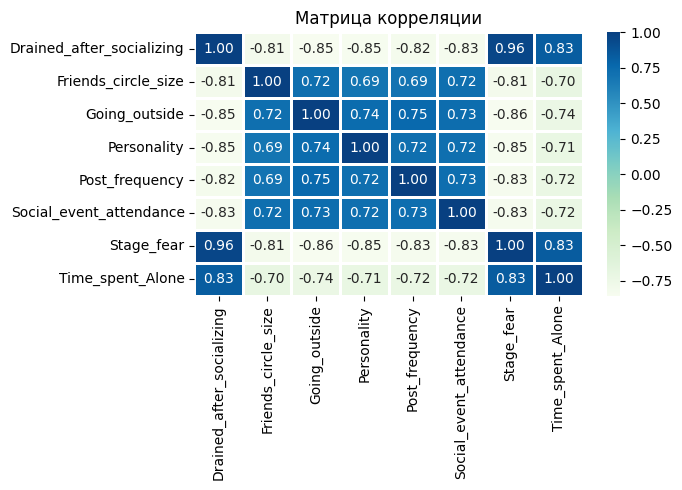

In [10]:
correlation_matrix = data[num_cols].corr()

plt.figure(figsize=(7, 5))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', linewidths=1, cmap='GnBu')
plt.title('Матрица корреляции')
plt.tight_layout()
plt.show()

7. Этап 5 — Подвыборка и матрица расстояний

In [11]:
def compute_distance_matrix(data, metric):
    n = len(data)
    matrix = [[0.0 for _ in range(n)] for _ in range(n)]
    for i in range(n):
        for j in range(n):
            if i != j:
                if metric == 'euclidean':
                    dist = euclidean_distance2(data[i], data[j])
                elif metric == 'manhattan':
                    dist = manhattan_distance(data[i], data[j])
                elif metric == 'chebyshev':
                    dist = chebyshev_distance(data[i], data[j])
                elif metric == 'minkowski':
                    dist = minkowski_distance(data[i], data[j], 2, 3)
                elif metric == 'mahalanobis':
                    dist = mahalanobis_distance(data[i], data[j], np.linalg.inv(np.cov(np.array(data).T)))
                elif metric == 'spearman':
                    dist = spearman_rank_correlation(data[i], data[j])
                elif metric == 'kendall':
                    dist = kendall_tau(data[i], data[j])
                elif metric == 'pearson':
                    dist = pearson_correlation(data[i], data[j])
                matrix[i][j] = dist
    return matrix

X = data.sample(frac=0.4, random_state=42).reset_index(drop=True)
X_t = compute_distance_matrix(X.values, 'euclidean')
pd.DataFrame(X_t).head()


,0,1,2,3,4,5,6,7,8,9,...,1150,1151,1152,1153,1154,1155,1156,1157,1158,1159
0,0.000000,3.740385,0.601396,0.110408,0.428054,0.157675,0.598972,3.660923,0.670264,0.128673,...,0.445905,3.772215,1.251451,0.417929,4.317966,4.101299,4.227607,4.556446,0.241938,0.178264
1,3.740385,0.000000,4.630415,4.271693,4.518699,4.390672,4.297178,0.078199,4.606838,3.957678,...,4.427936,0.374789,3.496001,3.792870,0.552986,0.574853,0.633440,0.409434,4.598034,4.407996
2,0.601396,4.630415,0.000000,0.356022,0.060836,0.367929,0.048264,4.546712,0.068673,0.324975,...,0.156042,4.722222,1.296612,0.201008,4.797587,4.343142,4.736540,4.911396,0.405298,0.548972
3,0.110408,4.271693,0.356022,0.000000,0.196013,0.053117,0.433598,4.100447,0.385707,0.098264,...,0.233864,4.230923,1.086077,0.387521,4.722523,4.479190,4.712165,5.166854,0.109897,0.048673
4,0.428054,4.518699,0.060836,0.196013,0.000000,0.177084,0.088825,4.430551,0.122566,0.164691,...,0.108264,4.679395,1.118825,0.206013,4.865934,4.542600,4.905162,5.028632,0.232231,0.335905


8. Этап 6 — Гистограмма расстояний

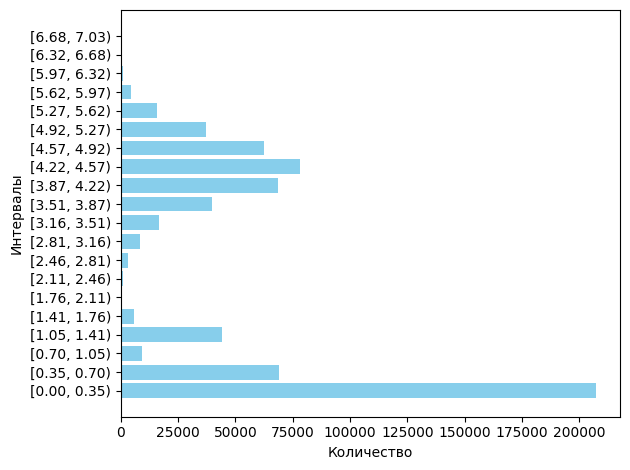

In [12]:
def build_distance_histogram(distance_matrix, bins=20):
    n = len(distance_matrix)
    distances = []
    for i in range(n):
        for j in range(i + 1, n):
            distances.append(distance_matrix[i][j])
    
    min_d, max_d = min(distances), max(distances)
    step = (max_d - min_d) / bins
    histogram = [0] * bins
    for d in distances:
        index = int((d - min_d) / step)
        if index == bins:
            index -= 1
        histogram[index] += 1
    
    binss = [f"[{min_d + i * step:.2f}, {min_d + (i + 1) * step:.2f})" for i in range(bins)]
    plt.barh(binss, histogram, color='skyblue')
    plt.xlabel('Количество')
    plt.ylabel('Интервалы')
    plt.tight_layout()
    plt.show()

build_distance_histogram(X_t)


9. Этап 7 — Кластеризация по Вроцлавской таксономии

Порог: 0.1500, Кластеры: 6, Внутрикластерный разброс: 144.8779
Порог: 0.1393, Кластеры: 6, Внутрикластерный разброс: 144.8779
Порог: 0.1286, Кластеры: 6, Внутрикластерный разброс: 144.8779
Порог: 0.1179, Кластеры: 7, Внутрикластерный разброс: 144.5393
Порог: 0.1071, Кластеры: 8, Внутрикластерный разброс: 144.4500
Порог: 0.0964, Кластеры: 9, Внутрикластерный разброс: 144.0557
Порог: 0.0857, Кластеры: 13, Внутрикластерный разброс: 143.5143
Порог: 0.0750, Кластеры: 14, Внутрикластерный разброс: 143.4679
Порог: 0.0643, Кластеры: 15, Внутрикластерный разброс: 143.4314
Порог: 0.0536, Кластеры: 21, Внутрикластерный разброс: 141.6080
Порог: 0.0429, Кластеры: 43, Внутрикластерный разброс: 137.1404
Порог: 0.0321, Кластеры: 91, Внутрикластерный разброс: 123.8601
Порог: 0.0214, Кластеры: 295, Внутрикластерный разброс: 60.4605
Порог: 0.0107, Кластеры: 697, Внутрикластерный разброс: 6.5301
Порог: 0.0000, Кластеры: 1160, Внутрикластерный разброс: 0.0000


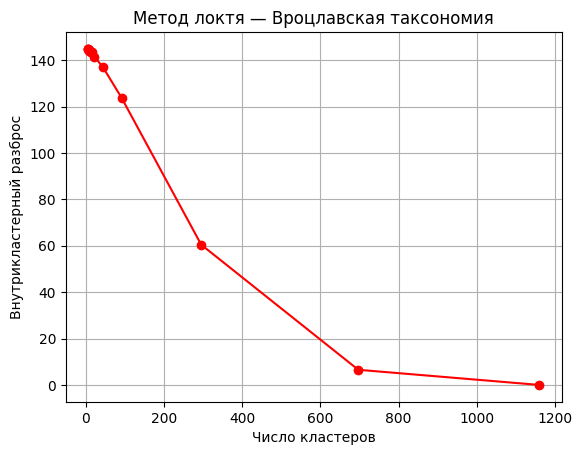

Порог: 0.13, Кластеры: 6


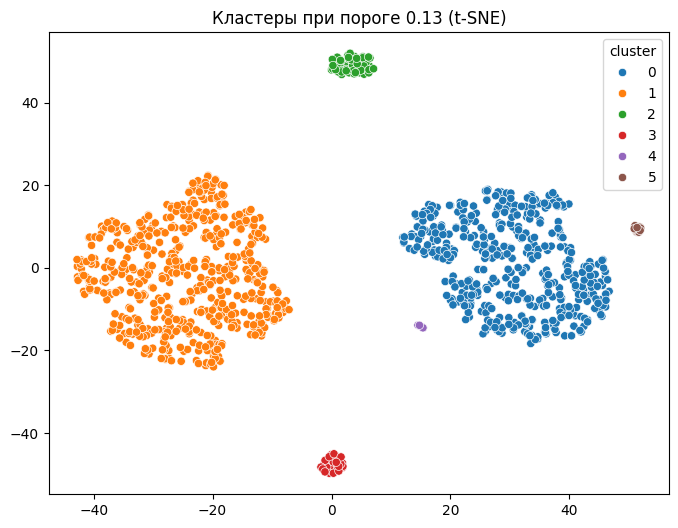

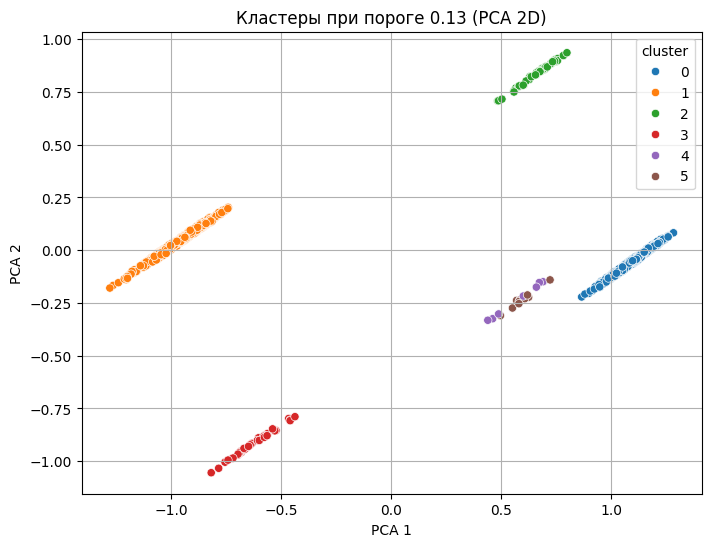

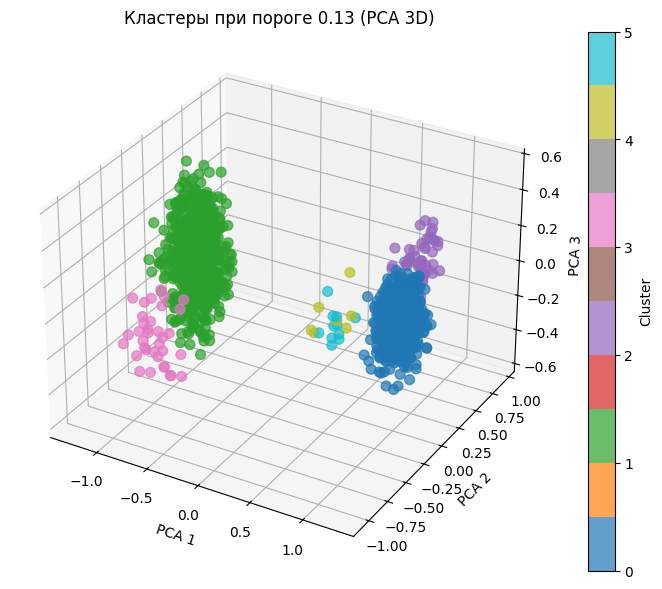

In [13]:
class WroclawTaxonomyClustering:
    def __init__(self, distance_matrix):
        self.distance_matrix = distance_matrix
        self.n = len(distance_matrix)
        self.graph = nx.Graph()
        self.graph.add_nodes_from(range(self.n))

    def cluster_with_threshold(self, threshold):
        self.graph.clear_edges()
        for i in range(self.n):
            for j in range(i + 1, self.n):
                if self.distance_matrix[i][j] < threshold:
                    self.graph.add_edge(i, j)
        components = list(nx.connected_components(self.graph))
        return [list(c) for c in components]

def compute_within_cluster_distance(distance_matrix, clusters):
    total = 0.0
    for cluster in clusters:
        if len(cluster) == 0:
            continue
        center = np.mean(X.iloc[cluster].values, axis=0)
        for i in cluster:
            v = X.iloc[i].values - center
            total += np.dot(v, v)
    return total

def wroclaw_taxonomy_elbow(distance_matrix, thresholds):
    scores = []
    cluster_counts = []
    for t in thresholds:
        clustering = WroclawTaxonomyClustering(distance_matrix)
        clusters = clustering.cluster_with_threshold(t)
        cluster_counts.append(len(clusters))
        score = compute_within_cluster_distance(distance_matrix, clusters)
        scores.append(score)
        print(f"Порог: {t:.4f}, Кластеры: {len(clusters)}, Внутрикластерный разброс: {score:.4f}")

    plt.plot(cluster_counts, scores, 'ro-')
    plt.xlabel('Число кластеров')
    plt.ylabel('Внутрикластерный разброс')
    plt.title('Метод локтя — Вроцлавская таксономия')
    plt.grid(True)
    plt.show()
    return scores

# 1 датасет
# thresholds = np.linspace(0.01, 0.081, num=15)[::-1]
# 2 датасет
thresholds = np.linspace(0, 0.15, num=15)[::-1]
wroclaw_taxonomy_elbow(X_t, thresholds)

# 1. Кластеризация с выбранным порогом
chosen_threshold = 0.13
clustering = WroclawTaxonomyClustering(X_t)
clusters = clustering.cluster_with_threshold(chosen_threshold)

# Присвоение меток кластеров
cluster_labels = np.full(X.shape[0], -1)
for idx, cluster in enumerate(clusters):
    for item in cluster:
        cluster_labels[item] = idx

X['cluster'] = cluster_labels

print(f"Порог: {chosen_threshold}, Кластеры: {len(clusters)}")

# 2. Визуализация t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(X.drop(columns=['cluster']))

plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=X['cluster'], palette='tab10', legend='full')
plt.title(f'Кластеры при пороге {chosen_threshold} (t-SNE)')
plt.show()

# 3. Визуализация PCA 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X.drop(columns=['cluster']))

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=X['cluster'], palette='tab10', legend='full')
plt.title(f'Кластеры при пороге {chosen_threshold} (PCA 2D)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid(True)
plt.show()

# 4. Визуализация PCA 3D
from mpl_toolkits.mplot3d import Axes3D

pca_3d = PCA(n_components=3)
pca_result_3d = pca_3d.fit_transform(X.drop(columns=['cluster']))

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    pca_result_3d[:, 0], pca_result_3d[:, 1], pca_result_3d[:, 2],
    c=X['cluster'], cmap='tab10', s=50, alpha=0.7
)

ax.set_title(f'Кластеры при пороге {chosen_threshold} (PCA 3D)')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
fig.colorbar(scatter, ax=ax, label='Cluster')
plt.show()


Вывод статистики по кластерам

In [ ]:
# Сопоставление числовых значений типам личности
personality_map = {0.0: 'Интроверт', 1.0: 'Экстраверт'}

print("Описание кластеров:\n")

for cluster_id in sorted(X['cluster'].unique()):
    cluster_data = X[X['cluster'] == cluster_id]
    dominant_personality_code = cluster_data['Personality'].mode()[0] if not cluster_data['Personality'].mode().empty else None
    dominant_personality = personality_map.get(dominant_personality_code, 'Неизвестно')

    print(f"\n - Кластер {cluster_id}:")
    print(f"  Размер: {len(cluster_data)} объектов")
    print(f"  Среднее время, проведённое в одиночестве: {cluster_data['Time_spent_Alone'].mean():.2f}")
    print(f"  Процент страдающих страхом сцены: {cluster_data['Stage_fear'].mean() * 100:.1f}%" if 'Stage_fear' in cluster_data else "  Нет данных о страхе сцены")
    print(f"  Средняя посещаемость соц. событий: {cluster_data['Social_event_attendance'].mean():.2f}")
    print(f"  Среднее количество выходов на улицу: {cluster_data['Going_outside'].mean():.2f}")
    print(f"  Процент уставших после общения: {cluster_data['Drained_after_socializing'].mean() * 100:.1f}%" if 'Drained_after_socializing' in cluster_data else "  Нет данных об усталости после общения")
    print(f"  Средний размер круга друзей: {cluster_data['Friends_circle_size'].mean():.2f}")
    print(f"  Средняя частота публикаций: {cluster_data['Post_frequency'].mean():.2f}")
    print(f"  Тип личности в кластере: {dominant_personality}")


Описание кластеров:


 - Кластер 0:
  Размер: 486 объектов
  Среднее время, проведённое в одиночестве: 0.68


KeyError: 'Stage_fear_num'

8 этап — Индекс силуэта для кластеризации Вроцлавской таксономии

=== Вроцлавская таксономия: Р М СК НЗ с индексом силуэта ===
Порог: 1.1000, Кластеры: 2, Внутрикластерный разброс: 908.1013, Silhouette: 0.6601691754741217
Порог: 1.0214, Кластеры: 2, Внутрикластерный разброс: 908.1013, Silhouette: 0.6601691754741217
Порог: 0.9429, Кластеры: 6, Внутрикластерный разброс: 144.8779, Silhouette: 0.7813317876228789
Порог: 0.8643, Кластеры: 6, Внутрикластерный разброс: 144.8779, Silhouette: 0.7813317876228789
Порог: 0.7857, Кластеры: 6, Внутрикластерный разброс: 144.8779, Silhouette: 0.7813317876228789
Порог: 0.7071, Кластеры: 6, Внутрикластерный разброс: 144.8779, Silhouette: 0.7813317876228789
Порог: 0.6286, Кластеры: 6, Внутрикластерный разброс: 144.8779, Silhouette: 0.7813317876228789
Порог: 0.5500, Кластеры: 6, Внутрикластерный разброс: 144.8779, Silhouette: 0.7813317876228789
Порог: 0.4714, Кластеры: 6, Внутрикластерный разброс: 144.8779, Silhouette: 0.7813317876228789
Порог: 0.3929, Кластеры: 6, Внутрикластерный разброс: 144.8779, Silhouette: 0.781331

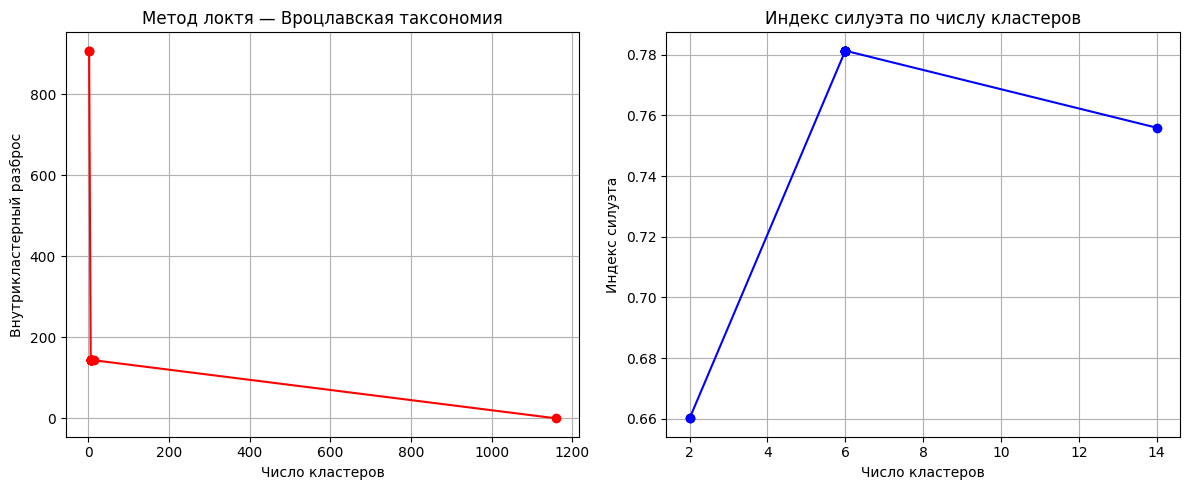

([np.float64(908.1013413713557),
  np.float64(908.1013413713557),
  np.float64(144.87787966945297),
  np.float64(144.87787966945297),
  np.float64(144.87787966945297),
  np.float64(144.87787966945297),
  np.float64(144.87787966945297),
  np.float64(144.87787966945297),
  np.float64(144.87787966945297),
  np.float64(144.87787966945297),
  np.float64(144.87787966945297),
  np.float64(144.8778796694529),
  np.float64(144.8778796694529),
  np.float64(143.4679444745496),
  np.float64(0.0)],
 [0.6601691754741217,
  0.6601691754741217,
  0.7813317876228789,
  0.7813317876228789,
  0.7813317876228789,
  0.7813317876228789,
  0.7813317876228789,
  0.7813317876228789,
  0.7813317876228789,
  0.7813317876228789,
  0.7813317876228789,
  0.7813317876228789,
  0.7813317876228789,
  0.7559551612147531,
  nan])

In [14]:
from sklearn.metrics import silhouette_score

def wroclaw_taxonomy_elbow_with_silhouette(distance_matrix, thresholds):
    print("=== Вроцлавская таксономия: Р М СК НЗ с индексом силуэта ===")
    scores = []
    silhouettes = []
    cluster_counts = []

    for t in thresholds:
        clustering = WroclawTaxonomyClustering(distance_matrix)
        clusters = clustering.cluster_with_threshold(t)
        cluster_counts.append(len(clusters))
        score = compute_within_cluster_distance(distance_matrix, clusters)

        labels = np.zeros(len(distance_matrix), dtype=int)
        for cluster_id, cluster in enumerate(clusters):
            for index in cluster:
                labels[index] = cluster_id

        n_clusters = len(set(labels))
        if 1 < n_clusters < len(distance_matrix):
            silhouette = silhouette_score(X.values, labels, metric='euclidean')
        else:
            silhouette = np.nan

        scores.append(score)
        silhouettes.append(silhouette)

        print(f"Порог: {t:.4f}, Кластеры: {len(clusters)}, Внутрикластерный разброс: {score:.4f}, Silhouette: {silhouette}")

    filtered_counts = [c for c, s in zip(cluster_counts, silhouettes) if not np.isnan(s)]
    filtered_silhouettes = [s for s in silhouettes if not np.isnan(s)]

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(cluster_counts, scores, 'ro-')
    plt.xlabel('Число кластеров')
    plt.ylabel('Внутрикластерный разброс')
    plt.title('Метод локтя — Вроцлавская таксономия')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(filtered_counts, filtered_silhouettes, 'bo-')
    plt.xlabel('Число кластеров')
    plt.ylabel('Индекс силуэта')
    plt.title('Индекс силуэта по числу кластеров')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return scores, silhouettes

# 1 датасет
# thresholds = np.linspace(0.01, 0.081, num=15)
# 2 датасет
thresholds = np.linspace(0, 1.1, num=15)
wroclaw_taxonomy_elbow_with_silhouette(X_t, thresholds[::-1])

 Индекс Калински-Харабаша для кластеров Вроцлавской таксономии

=== Вроцлавская таксономия с индексом Калински-Харабаша ===
Порог: 1.0500, Кластеры: 2, Индекс Калински-Харабаша: 1674.654762350509
Порог: 0.9750, Кластеры: 6, Индекс Калински-Харабаша: 3307.976445130826
Порог: 0.9000, Кластеры: 6, Индекс Калински-Харабаша: 3307.976445130826
Порог: 0.8250, Кластеры: 6, Индекс Калински-Харабаша: 3307.976445130826
Порог: 0.7500, Кластеры: 6, Индекс Калински-Харабаша: 3307.976445130826
Порог: 0.6750, Кластеры: 6, Индекс Калински-Харабаша: 3307.976445130826
Порог: 0.6000, Кластеры: 6, Индекс Калински-Харабаша: 3307.976445130826
Порог: 0.5250, Кластеры: 6, Индекс Калински-Харабаша: 3307.976445130826
Порог: 0.4500, Кластеры: 6, Индекс Калински-Харабаша: 3307.976445130826
Порог: 0.3750, Кластеры: 6, Индекс Калински-Харабаша: 3307.976445130826
Порог: 0.3000, Кластеры: 6, Индекс Калински-Харабаша: 3307.976445130826
Порог: 0.2250, Кластеры: 6, Индекс Калински-Харабаша: 3307.976445130826
Порог: 0.1500, Кластеры: 6, Индекс Калински-Харабаша: 3307.976445130826
Поро

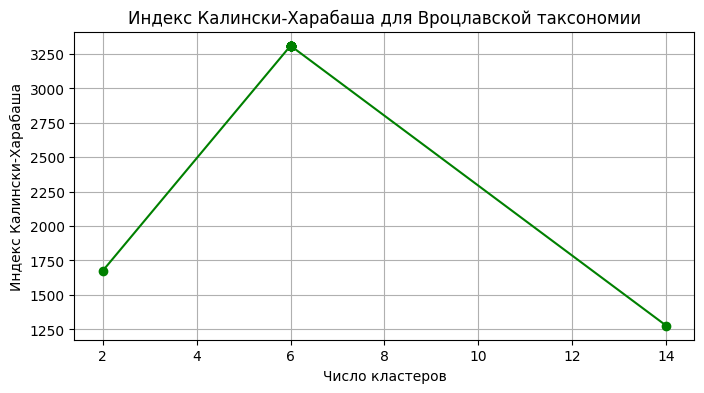

[1674.654762350509,
 3307.976445130826,
 3307.976445130826,
 3307.976445130826,
 3307.976445130826,
 3307.976445130826,
 3307.976445130826,
 3307.976445130826,
 3307.976445130826,
 3307.976445130826,
 3307.976445130826,
 3307.976445130826,
 3307.976445130826,
 1276.761742899867,
 nan]

In [15]:
from sklearn.metrics import calinski_harabasz_score

def wroclaw_taxonomy_with_calinski(distance_matrix, thresholds):
    print("=== Вроцлавская таксономия с индексом Калински-Харабаша ===")
    ch_scores = []
    cluster_counts = []

    for t in thresholds:
        clustering = WroclawTaxonomyClustering(distance_matrix)
        clusters = clustering.cluster_with_threshold(t)
        cluster_counts.append(len(clusters))

        labels = np.zeros(len(distance_matrix), dtype=int)
        for cluster_id, cluster in enumerate(clusters):
            for index in cluster:
                labels[index] = cluster_id

        if 1 < len(set(labels)) < len(distance_matrix):
            ch_score = calinski_harabasz_score(X.values, labels)
        else:
            ch_score = np.nan

        ch_scores.append(ch_score)
        print(f"Порог: {t:.4f}, Кластеры: {len(clusters)}, Индекс Калински-Харабаша: {ch_score}")

    filtered_counts = [c for c, s in zip(cluster_counts, ch_scores) if not np.isnan(s)]
    filtered_scores = [s for s in ch_scores if not np.isnan(s)]

    plt.figure(figsize=(8,4))
    plt.plot(filtered_counts, filtered_scores, 'go-')
    plt.xlabel('Число кластеров')
    plt.ylabel('Индекс Калински-Харабаша')
    plt.title('Индекс Калински-Харабаша для Вроцлавской таксономии')
    plt.grid(True)
    plt.show()

    return ch_scores

# 1 датасет
# thresholds = np.linspace(0.01, 0.081, num=15)
# 2 датасет
thresholds = np.linspace(0, 1.05, num=15)
wroclaw_taxonomy_with_calinski(X_t, thresholds[::-1])